$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Neural Networks

*Jason Stock  
CS 440: Introduction to Artificial Intelligence*

## Overview

This notebook will explore the the use of neural networks to make predictive regression and classification analyses.  The data used for each experiment will be defined below.  Both algorithms utilize the same Scaled Conjugate Gradient algorithm to assist training our neural networks.  The following python functions will be imported to handle the large computations as courtesy of Dr. Chuck Anderson:

* `neuralnetworks.py`
* `scaledconjugategradient.py`
* `mlutils.py`

A simple example of fitting data to a piecewise linear function can be shown by using the classes above to create, train, and use our neural network.  First, sample data will randomly be generated and then the network can be used.  A matrix of input data is labeled `X`, a matrix of target data `T`, and used to compute a desired output matrix `Y`.  

Initializing the neural network take the parameters `(number of features, network structure, number of outputs)`, such that the network can be trained by specifying *some* arguments `(input data, target data, training iterations)`.  This can better be understood shown below.

In [12]:
#  Imports

import neuralnetworks as nn
import mlutils as ml

import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from pprint import pprint
%config InlineBackend.figure_format = 'retina'

X: 10 samples with 1 feature.
Y: 10 samples with 1 output.


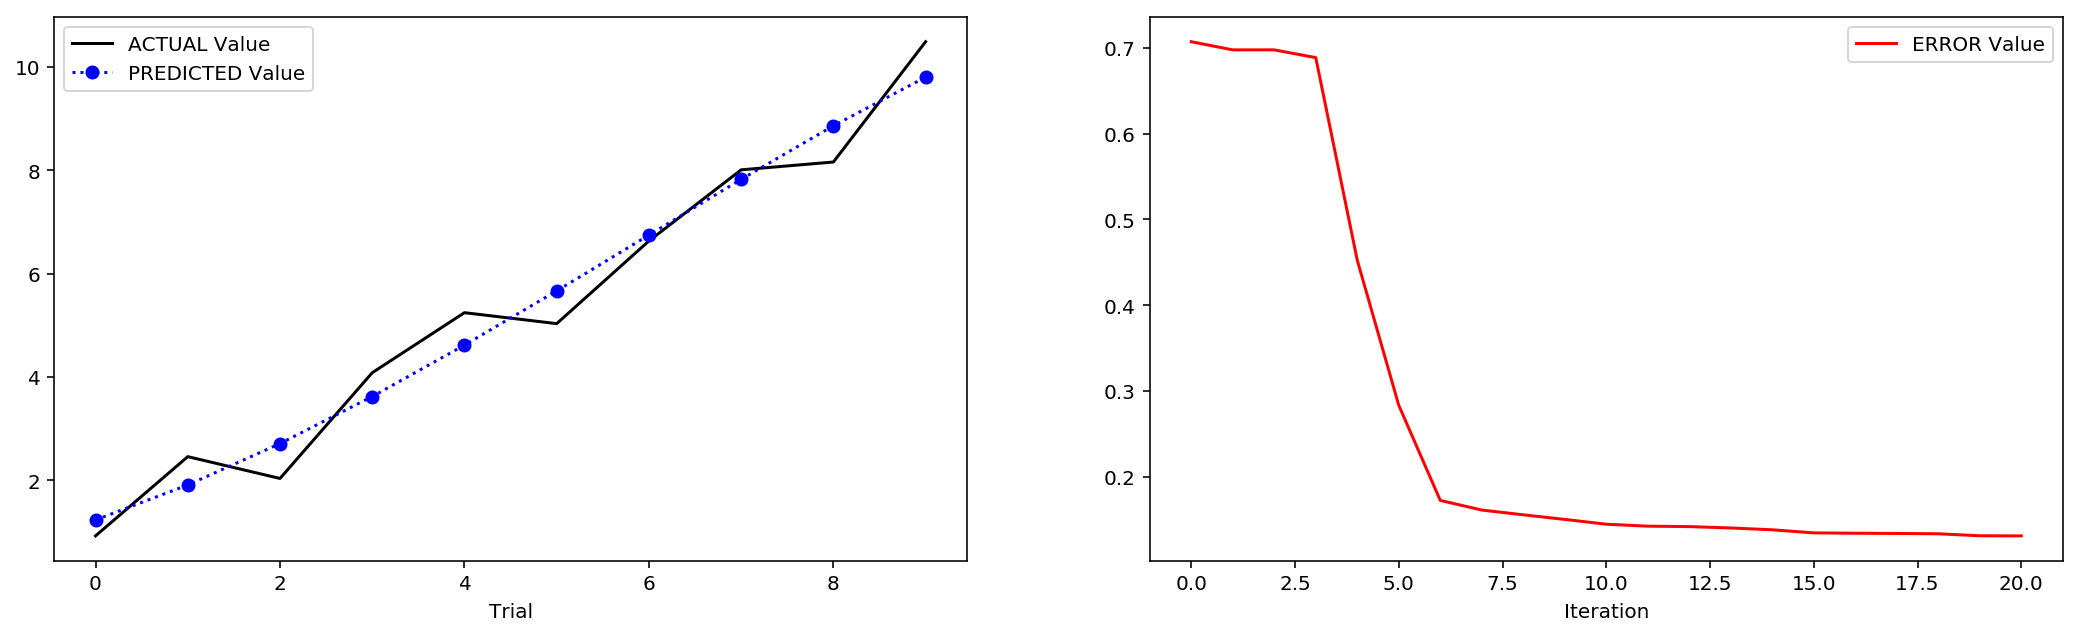

In [3]:
X = np.arange(10).reshape((-1, 1))
T = X + 1 + np.random.uniform(-1, 1, (10,1))
print('X:', X.shape[0], 'samples with', X.shape[1], 'feature.')
print('Y:', T.shape[0], 'samples with', T.shape[1], 'output.')

nnet = nn.NeuralNetwork(X.shape[1], [2, 4], T.shape[1])
nnet.train(X, T, 20)
Y = nnet.use(X)

plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(T, 'k-');
plt.plot(Y, 'ob:')
plt.xlabel('Trial')
plt.legend(['ACTUAL Value', 'PREDICTED Value'])

plt.subplot(1,2,2)
plt.plot(nnet.getErrorTrace(), 'r-')
plt.xlabel('Iteration')
plt.legend(['ERROR Value'])

plt.show()

The above graph on the left is *okay*, showing that the predicted output values `Y` are fairly well represented of the data.  However, it is possible to do better! To gauge the progress of accuracy in the neural network, the error trace between iterations can be plotted as shown in the graph to the right.  The error indicates how far off the predicted is from the actual value. For a regression problem as above objective is to **decrease** the error between sample inputs and the target outputs, i.e., having a minimal error will result in a more accurate model.  A high error is a possible side-effect of having too many, or too few hidden layers or hidden units in the neural network, or maybe not training the network enough - without overfitting the data.  The previous example indicates a network with 10 samples of 1 input, 2 hidden layers with 2 and 4 units respectively, and 1 output, visually this can be seen as:

<img alt="" src=" " />

It is clear of the structure of units and hidden layers, but it is difficult to fully understand the weights within the units.  Let's visualize this!

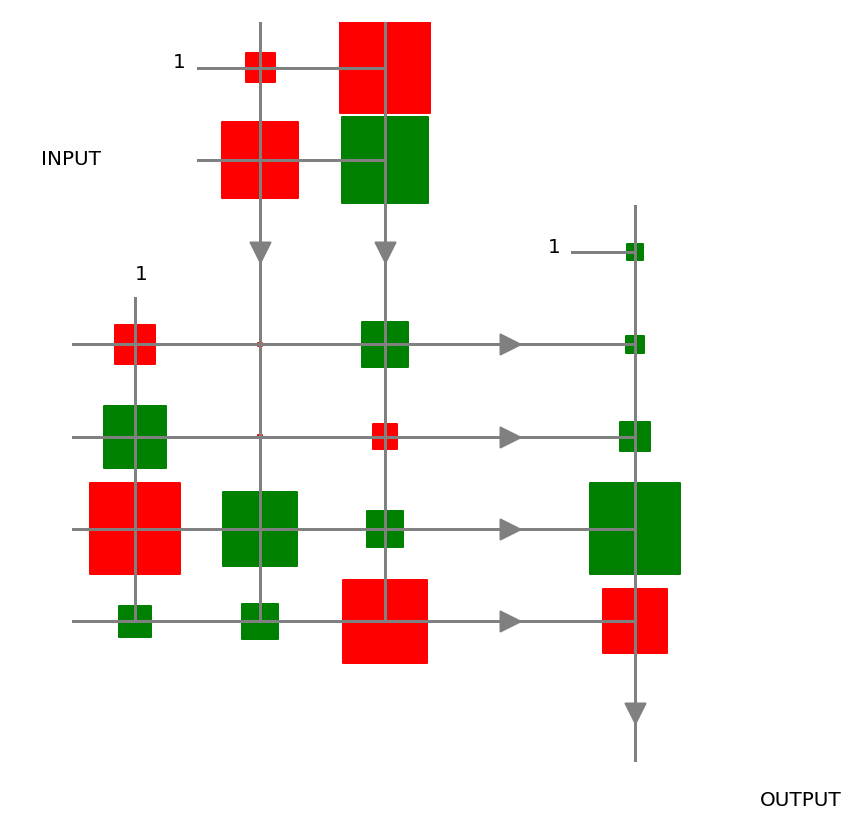

In [4]:
plt.figure(figsize=(7,7))
nnet.draw(['INPUT'], ['OUTPUT'])

Drawing the network shows the first hidden layer with two inputs at the top, a constant 1 and the input value from the sample feature.  This feeds into the first hidden layer with two units.  Such that the output is the input to the next hidden layer with four units.  The four outputs of this layer are the input to the output layer - which compute the final output value the given input.  

It can be seen that green and red boxes cover the intersection of the layers.  A green box represents a positive weight, and a red box represents a negative weight where the larger a box the larger magnitude it carries, i.e., a small box is closer to a weight of 0.

Actually finding the best network structure for more abstract data can be a rigorous process.  Which is why the following functions are defined to assist in getting more accurate results:

* `trainNNs`
* `summarize`
* `bestNetwork`

Appropriate use of the functions will be defined below, with a deeper analysis in the next sections.

In [5]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures,
             numberRepetitions, numberIterations, classify = False):
    train_p, test_p, timing = [], [], []
    for network in hiddenLayerStructures:
        l_train_p, l_test_p = [], []
        sT = time.time()
        for rep in range(0, numberRepetitions):
            Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T,
                                                        (trainFraction, 1 - trainFraction),
                                                        classification = classify)
            if classify:
                nnet = nn.NeuralNetworkClassifier(Xtrain.shape[1],
                                                  network,
                                                  np.unique(T).shape[0])
                nnet.train(Xtrain, Ttrain, numberIterations)
                
                Ytrain = nnet.use(Xtrain)
                Ytest  = nnet.use(Xtest)
                
                l_train_p.append( np.sum(Ytrain!=Ttrain)/len(Ttrain) )
                l_test_p.append( np.sum(Ytest!=Ttest)/len(Ttest) )
            else:
                nnet = nn.NeuralNetwork(Xtrain.shape[1],
                                        network,
                                        Ttrain.shape[1])
                nnet.train(Xtrain, Ttrain, numberIterations)
    
                Ytrain = nnet.use(Xtrain)
                Ytest  = nnet.use(Xtest)
            
                l_train_p.append( np.mean( (Ytrain - Ttrain)**2) )
                l_test_p.append( np.mean( (Ytest  - Ttest )**2) )

        timing.append((time.time() - sT))
        
        train_p.append(l_train_p)
        
        test_p.append(l_test_p)
        
    return [ [hiddenLayerStructures[i], train_p[i], test_p[i], timing[i]]
                for i in range(0, len(hiddenLayerStructures)) ]

def summarize(results):
    for i in range(0, len(results)):
        results[i][1] = np.mean(results[i][1])
        results[i][2] = np.mean(results[i][2])
    
    return results

def bestNetwork(summary):
    min_index = np.argmin( [ [x[2]] for x in summary ] )
    return summary[min_index]

def printBest(best):
    print('\nBest:', best)
    print('\nHidden Layers {} Average Training {:.2f} Testing {:.2f} ' \
          'Took {:.4f} seconds'.format(*best))

## Regression Experiment

For this experiment, [appliances energy prediction](http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction) data was downloaded from the UCI Machine Learning Repository. The goal is to discuss the use of predictive models for the energy use of appliances.  The data includes information every 10 minutes over 4.5 months of collected temperature and humidity measurements in a home, weather from a nearby airport, and energy usage of appliances and lighting fixtures in Wh (Watt Hours).

Before any machine learning, the data needs to be organized.  The function `fileOpener` will help to open a .csv file to divide into input and target data.


In [13]:
def fileOpener(path, x_cord, t_cord, classify=False):
    data = pd.read_csv(path)

    X = data.iloc[:, x_cord[0]:x_cord[1]]
    T = data.iloc[:, t_cord[0]:t_cord[1]]

    if classify:
        _, T = np.unique(T, return_inverse=True)
        T = [ [item] for item in T ]
        
    return np.array(X), np.array(T), data

The appliance data will be divided such that the first two columns - skipping the date, labeled Appliances and lights are used as the target variables, and the remaining 24 columns as the input features.  Let's open it up and take a look!

In [14]:
X, T, data = fileOpener('energydata_complete.csv', (3,27), (1,3))
data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


Great!  All the information as described above was opened, and it shows there are no categorical classifiers.  Only numerical data.  The first column **data**, and the last two nondimesional random variable columns **rv1** and **rv2** will be ignored. 

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
date           19735 non-null object
Appliances     19735 non-null int64
lights         19735 non-null int64
T1             19735 non-null float64
RH_1           19735 non-null float64
T2             19735 non-null float64
RH_2           19735 non-null float64
T3             19735 non-null float64
RH_3           19735 non-null float64
T4             19735 non-null float64
RH_4           19735 non-null float64
T5             19735 non-null float64
RH_5           19735 non-null float64
T6             19735 non-null float64
RH_6           19735 non-null float64
T7             19735 non-null float64
RH_7           19735 non-null float64
T8             19735 non-null float64
RH_8           19735 non-null float64
T9             19735 non-null float64
RH_9           19735 non-null float64
T_out          19735 non-null float64
Press_mm_hg    19735 non-null float64
RH_out         19735 n

In total, this data shows 19,735 samples, 24 feature columns, 2 target columns.  All of the feature data are 64-bit floats, and the target variables are 64-bit integers.  We will continue to get a better understanding of the data per column.

In [16]:
data.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


There are no missing values in the data as suggested by the count from each - which is great.  However, the more interesting part aspect is shown by the reasonable distribution per column given by the min, max, and quartile ranges (specifically over the lights information.  This will be discussed more below).  

The `fileOpener` function was also used to divide the data into the respective information. 

In [28]:
print('Shape of X:', X.shape, ', T:', T.shape, '\n')
print('First two items in X:\n', X[:2,:], '\n')
print('First two items in T:\n', T[:2,:])

Shape of X: (19735, 24) , T: (19735, 2) 

First two items in X:
 [[ 19.89        47.59666667  19.2         44.79        19.79
   44.73        19.          45.56666667  17.16666667  55.2
    7.02666667  84.25666667  17.2         41.62666667  18.2
   48.9         17.03333333  45.53         6.6        733.5
   92.           7.          63.           5.3       ]
 [ 19.89        46.69333333  19.2         44.7225      19.79
   44.79        19.          45.9925      17.16666667  55.2
    6.83333333  84.06333333  17.2         41.56        18.2
   48.86333333  17.06666667  45.56         6.48333333 733.6
   92.           6.66666667  59.16666667   5.2       ]] 

First two items in T:
 [[60 30]
 [60 30]]


The goal now is to use the the defined `trainNNs`, `summarize`, and `bestNetwork` functions on this data to investigate various network sizes.  From mlutils.py is the partition function that will be used to separate the input `X`, and target `T` into the training and testing data.  This is beneficial because then the accuracy of each model can better be represented on data that was not included in training.  For this experiment, the data will be distributed such that 80% is used for training and 20% used for testing.  The top network will be defined by the network with the lowest root mean squared error (RMSE) average.  

However, before partitioning the data it is important to see how many iterations are needed by plotting the error trace.  The function `UCI` is similar to `trainNNs`, but will return the error trace for a single network.  

Network 1: [8, 8, 8] with 100 iterations.
Network 2: [40, 40, 40] with 120 iterations.
Network 3: [5, 5] with 144 iterations.
Network 4: [4, 4, 4] with 172 iterations.
Network 5: [16, 16, 16, 16] with 206 iterations.
Network 6: [8] with 247 iterations.
Network 7: [40, 40, 40] with 296 iterations.
Network 8: [33, 33, 33, 33] with 355 iterations.
Network 9: [30, 30] with 426 iterations.
Network 10: [48, 48, 48] with 511 iterations.
Network 11: [28] with 613 iterations.
Network 12: [38] with 735 iterations.
Network 13: [12, 12, 12, 12] with 882 iterations.
Network 14: [27, 27, 27, 27] with 1058 iterations.


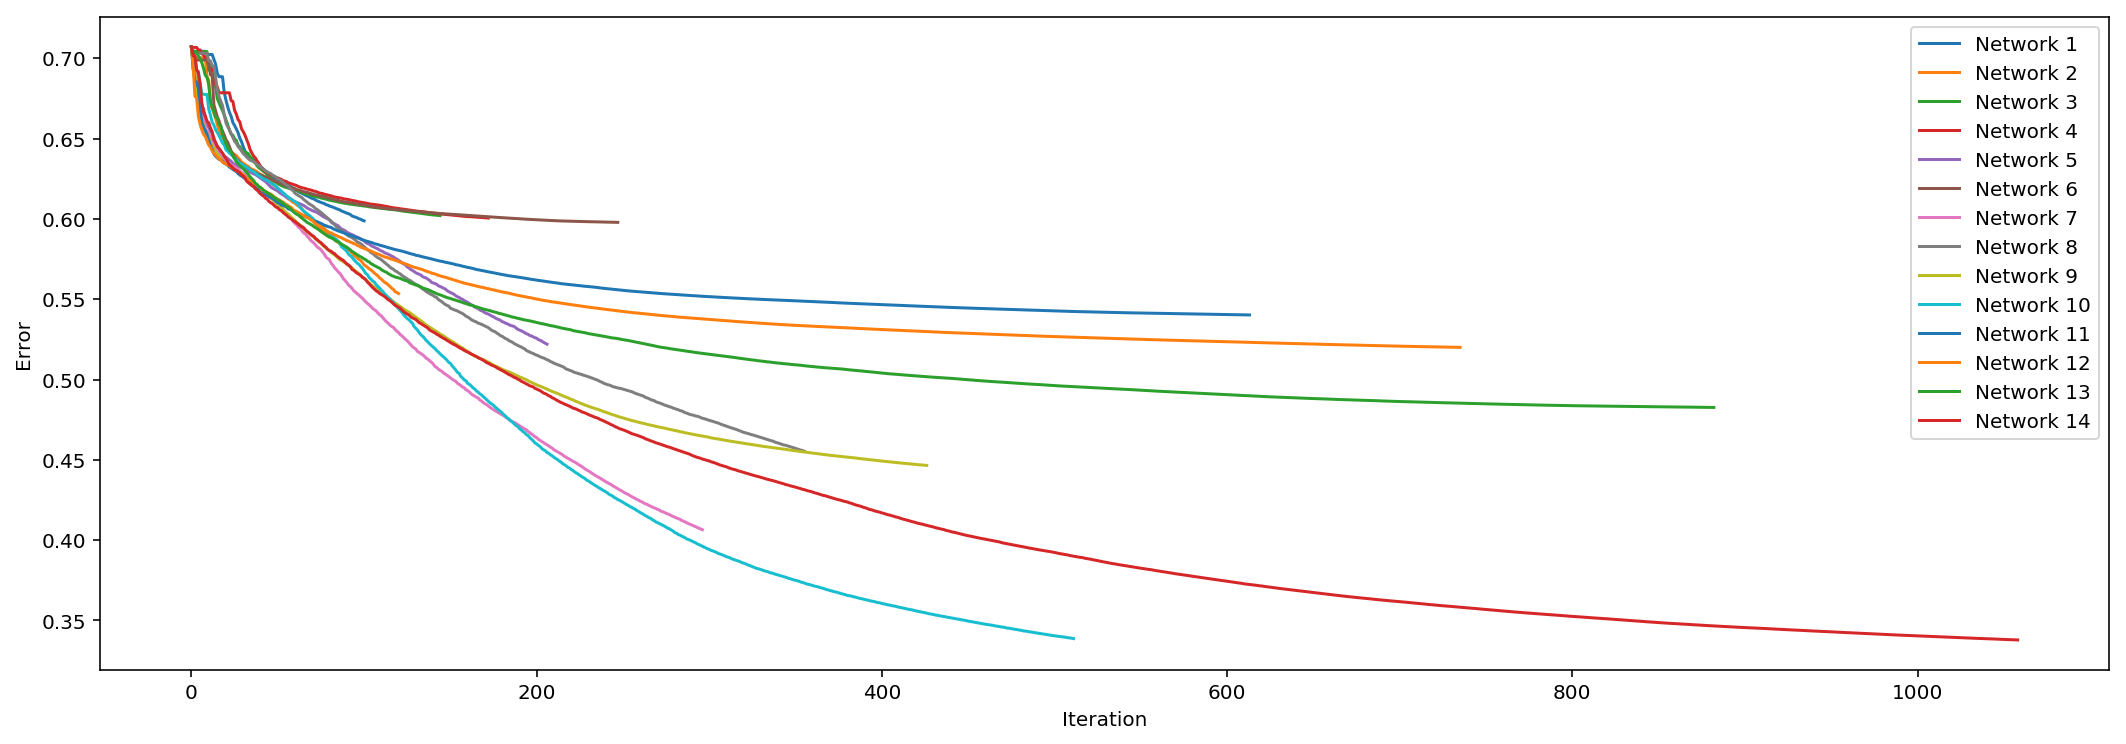

In [34]:
# returns the output, target, and error.  
# If partitioning, the test output and test target will be returned.
def UCI(X, T, network, itr, partition = False):
    if partition: 
        train_f = 0.8
        Xtrain, Ttrain, Xtest, T = ml.partition(X, T, (train_f, 1 - train_f))
        
        nnet = nn.NeuralNetwork(Xtrain.shape[1], network, Ttrain.shape[1])
        nnet.train(Xtrain, Ttrain, itr)
        Y = nnet.use(Xtest)
        
    else:  
        nnet = nn.NeuralNetwork(X.shape[1], network, T.shape[1]) 
        nnet.train(X, T, itr)
        Y = nnet.use(X)
        
    return Y, T, nnet.getErrorTrace()

numberItr = 100
er = []

for i in range(14):
    a = np.random.randint(1, 50)
    b = np.random.randint(1, 5)
    print('Network', str(i+1) + ':', [a]*b,
          'with', numberItr, 'iterations.')

    Y, _T, error = UCI(X, T, [a]*b, numberItr)
    er.append(error)
    numberItr = int(1.20 * numberItr)

plt.figure(figsize=(18,6))
for i, pl in enumerate(er):
    plt.plot(pl, label = 'Network '+str(i+1))

plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

The above graph shows that are were 14 trials of randomly generate networks that were created and plotted against the number of iterations (which increased by a factor of 1.20 after each trial).  Randomly generating the networks gives more variability to each trial, and allows to see potentially more results.  

It appeared that some networks, such as `[48, 48, 48]` reached an error minimum of 0.34 within 511 iterations while a network of `[12, 12, 12, 12]` after 882 iterations reached a minimum error of 0.50.  This is a good example of when gradient decent will get stuck at a local minimum that is not the global.  A network with the least minimum error, but over long iterations may be a sign that the data may be overfitted.  Though, it is clear from above that 100 iterations will not be enough as the error has a steep decent.  Given this, I will randomly generate more networks, and partition the data with **500** iterations over 3 repetitions for an accurate average.

In [36]:
itr = 500
hidden = []
trainFraction = 0.80
numberRepetitions = 3

for i in range(10):
    a = np.random.randint(1, 50)
    b = np.random.randint(2, 5)
    hidden.append([a]*b)

results = trainNNs(X, T, trainFraction, hidden,
                   numberRepetitions, itr)
summary = summarize(results)
best    = bestNetwork(summary)

pprint(summary)
printBest(best)

[[[38, 38, 38, 38], 1623.0206611988312, 3285.264692455614, 81.22736382484436],
 [[28, 28], 2258.5484755013517, 3549.161410403971, 26.060436010360718],
 [[1, 1, 1], 4931.880835474555, 5039.468973092914, 6.5101540088653564],
 [[34, 34], 1998.5191821996184, 3045.5734735218107, 33.492209911346436],
 [[12, 12, 12], 2933.2246676641894, 4113.924971760938, 19.216439962387085],
 [[16, 16], 3029.6562636578656, 3680.8383679090607, 16.293457984924316],
 [[37, 37, 37, 37], 1741.8774006675146, 3120.809868020246, 79.19186401367188],
 [[47, 47, 47, 47], 1357.270349879572, 2813.059676631139, 118.40529704093933],
 [[21, 21, 21], 2069.384027956489, 3304.6285843103283, 33.25830292701721],
 [[25, 25, 25, 25], 1786.283197858488, 3677.034658309702, 46.9923357963562]]

Best: [[47, 47, 47, 47], 1357.270349879572, 2813.059676631139, 118.40529704093933]

Hidden Layers [47, 47, 47, 47] Average Training 1357.27 Testing 2813.06 Took 118.4053 seconds


Therefore, the best network was seen to be `[47, 47, 47, 47]` (this may very per trial due to the randomness of the defined network structures), but this can be used with the `UCI` function to train a partition to 0.80 of the data, and plotted with `UCI_plotter`.  This plotter function takes a bound to specify how much of the data to graph.  Showing too much can make it difficult to make conclusions visually.

Network: [47, 47, 47, 47]
ERROR MIN: 0.3520078140811983 for 500 iterations
RMSE: 3362.034033423594


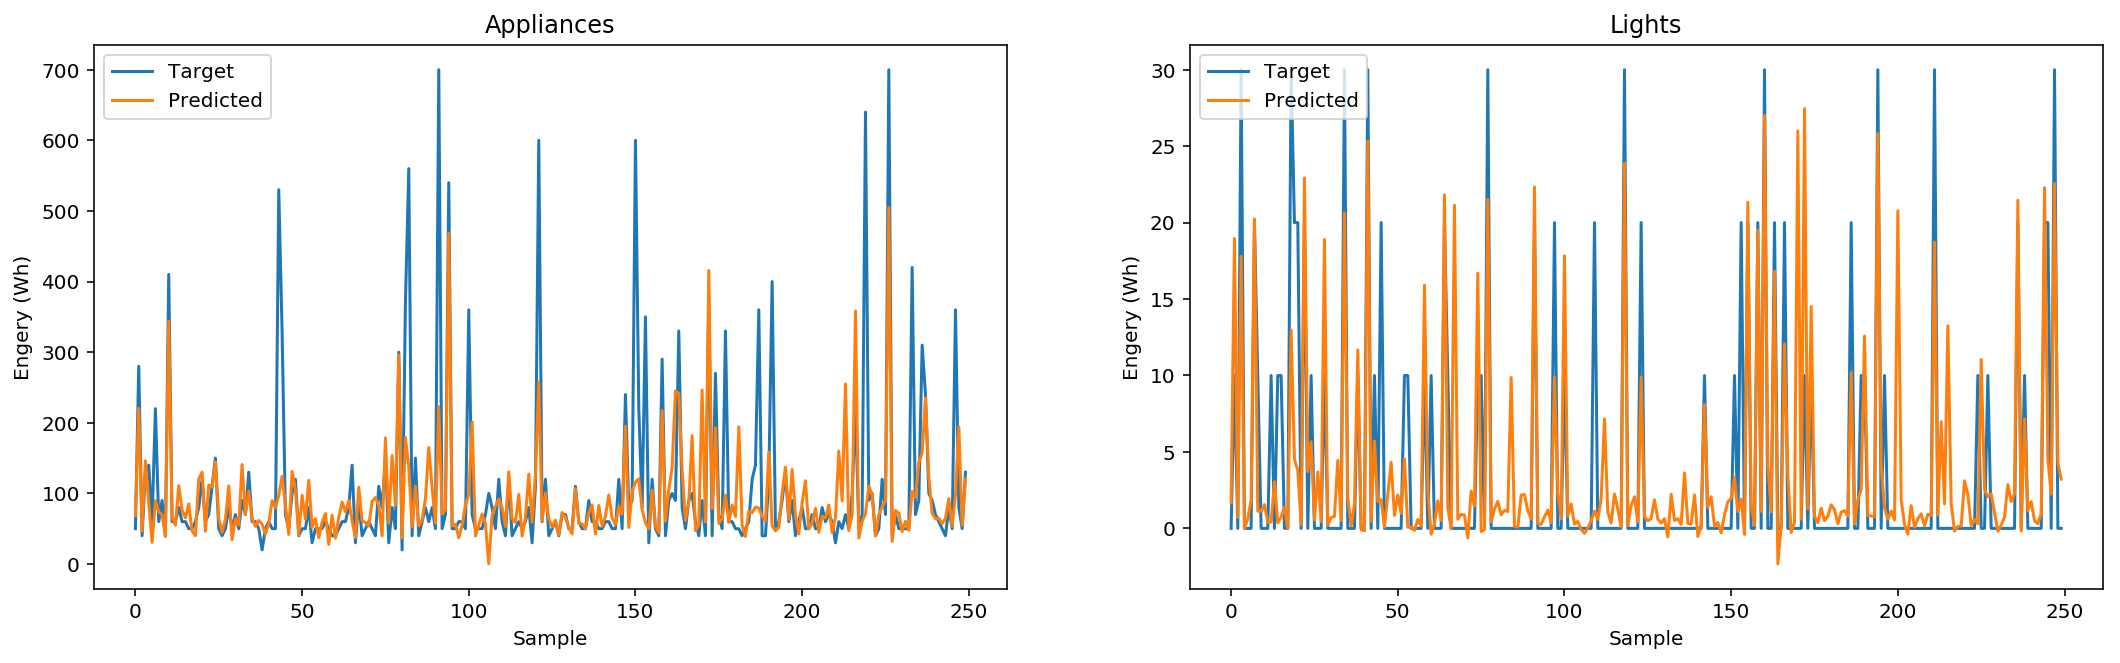

In [38]:
def UCI_plot(Y, T, error, itr, bound):
    print('ERROR MIN:', np.min(error), 'for', itr, 'iterations')
    print('RMSE:', np.mean((Y - T)**2))

    plt.figure(figsize=(18,5))
    plt.subplot(1,2,1)  
    plt.plot(T[:bound,0]), plt.plot(Y[:bound,0])
    plt.title('Appliances')
    plt.xlabel('Sample'), plt.ylabel('Engery (Wh)')
    plt.legend(['Target', 'Predicted'], loc='upper left')

    plt.subplot(1,2,2)  
    plt.plot(T[:bound,1]), plt.plot(Y[:bound,1])
    plt.title('Lights')
    plt.xlabel('Sample'), plt.ylabel('Engery (Wh)')
    plt.legend(['Target', 'Predicted'], loc='upper left')
    plt.show() 
    
itr = 500
bound = 250
network = [47, 47, 47, 47]
print('Network:', network)
Y, _T, error = UCI(X, T, network, itr, partition = True)
UCI_plot(Y, _T, error, itr, bound)

The above graphs show the predicted output values against the actual target values for the 20% partition. A bound of 250 was set such that there are only the first 200 samples being displayed on each graph. It is pretty evident that the network modeled the data pretty accurately. 

Another interpretation can be seen by plotting the target values against the actual - sample by sample.  Below, the two plots represent that for every sample the actual value along the x-axis and each *corresponding* output value on that y-axis.  In a perfect scenario, this will be a linear line over the samples.

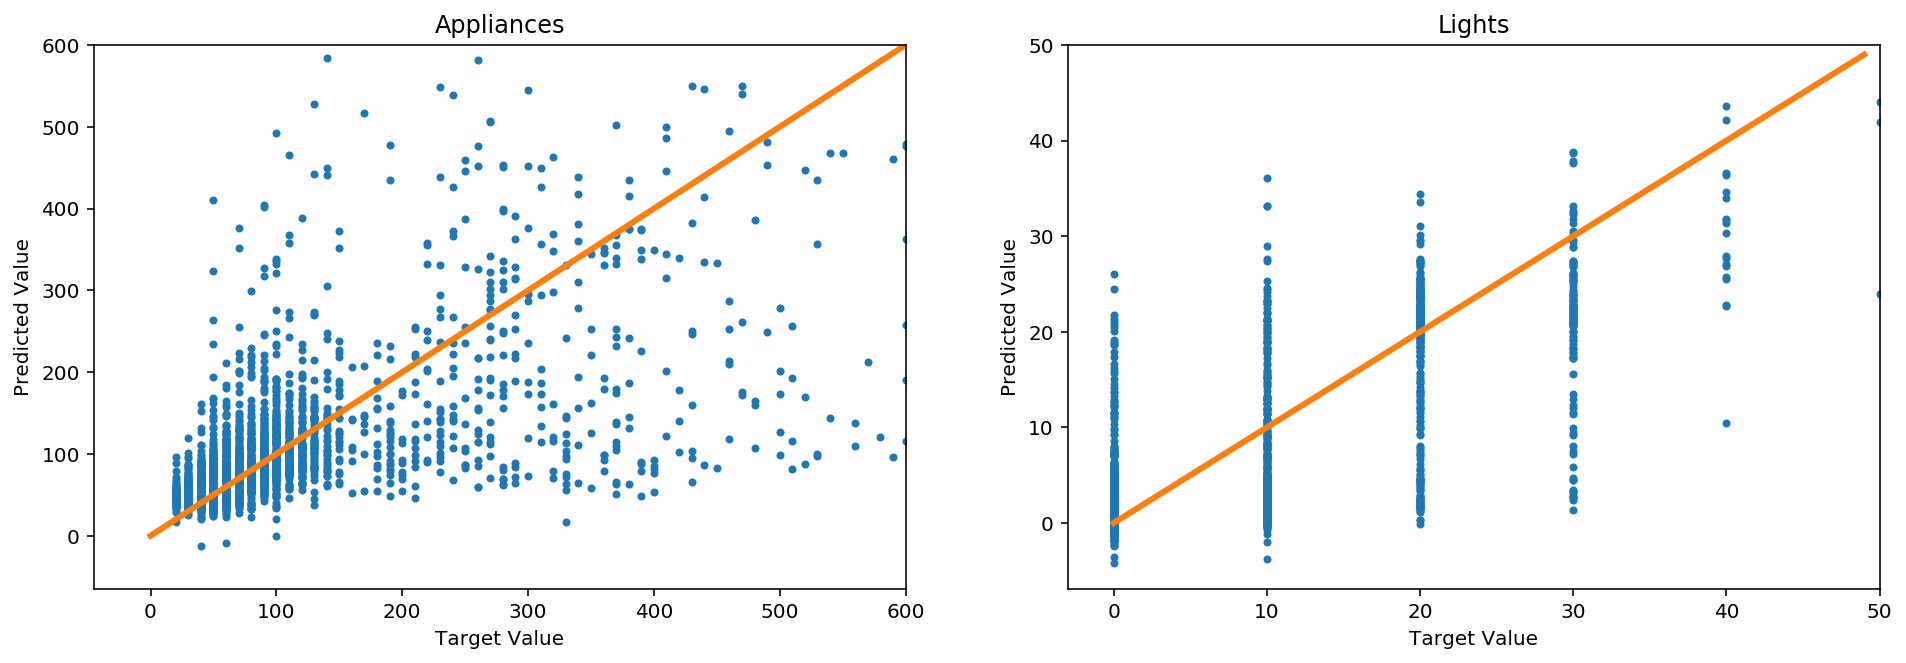

In [43]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)  
plt.plot(_T[:,0], Y[:,0], '.'), plt.plot(range(600), linewidth='3')
axes = plt.gca()
axes.set_xlim([None,600]), axes.set_ylim([None,600])
plt.title('Appliances')
plt.xlabel('Target Value'), plt.ylabel('Predicted Value')

plt.subplot(1,2,2)  
plt.plot(_T[:,1], Y[:,1], '.'), plt.plot(range(50), linewidth='3')
axes = plt.gca()
axes.set_xlim([None,50]), axes.set_ylim([None,50])
plt.title('Lights')
plt.xlabel('Target Value'), plt.ylabel('Predicted Value')
plt.show()

Graphic representations as above give a good indication that data is fairly sparse.  Especially is building an accurate model for the Watt Hour usage of lights (the plot on the right).  Target values are distributed over 10 unit measurements, and it can be seen that predicting the lights usage is often misinterpreted as a different value other than the target.  Each grouping of values spread from roughly 0 - 25 Wh regardless of the feature values. However, the average over the 19,735 samples is 3.801875 Wh with a standard deviation of 7.935988, but the upper quartile falls around 0.  Meaning, 75% of the data is actually a zero.  Looking at the line chart above it is more evident that there is *noise* in this data resulting in such a large range of values.

The model represents the data of the appliance usage far better.  Over the 19,735 samples, the mean appliance usage is 97.694958 Wh with a standard deviation of 102.524891 where 75% of the data falls around 100 Wh.  The plot on the left shows a grouping of values over most of the data.  Sample features at 100 are well condensed, and accurately predicted with $\pm$ the standard deviation misrepresented.

## Classification Experiment

For this experiment, [Anuran Calls (MFCCs)](http://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29) data was downloaded from the UCI Machine Learning Repository. The goal is to discuss the use of predictive models for the classification of species. The data includes audible samples segmented 60 audio recordings into 4 different families, 8 genus, and 10 species.  Each audio corresponds to an individual frog.  The idea is to recognize the anuran species from their individual calls.

This experiment will be slightly different than the last since we will be classifying the inputs with the given inputs.  Similar to the previous experiment, before any machine learning, the data needs to be organized. The `fileOpener` function will help to open a .csv file to divide into input and target data.

In [49]:
X, T, data = fileOpener('Frogs_MFCCs.csv', 
                        (1,22), (24,25), classify=True)
data.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


The columns that are prepended with MFCCs correspond to the mel-frequency cepstral coefficients where the values were normalized between -1 and +1.  The last few columns are the classifiers corresponding to the audible frequencies of that row.  We will focus on classifying **species**.

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7195 entries, 0 to 7194
Data columns (total 26 columns):
MFCCs_ 1    7195 non-null float64
MFCCs_ 2    7195 non-null float64
MFCCs_ 3    7195 non-null float64
MFCCs_ 4    7195 non-null float64
MFCCs_ 5    7195 non-null float64
MFCCs_ 6    7195 non-null float64
MFCCs_ 7    7195 non-null float64
MFCCs_ 8    7195 non-null float64
MFCCs_ 9    7195 non-null float64
MFCCs_10    7195 non-null float64
MFCCs_11    7195 non-null float64
MFCCs_12    7195 non-null float64
MFCCs_13    7195 non-null float64
MFCCs_14    7195 non-null float64
MFCCs_15    7195 non-null float64
MFCCs_16    7195 non-null float64
MFCCs_17    7195 non-null float64
MFCCs_18    7195 non-null float64
MFCCs_19    7195 non-null float64
MFCCs_20    7195 non-null float64
MFCCs_21    7195 non-null float64
MFCCs_22    7195 non-null float64
Family      7195 non-null object
Genus       7195 non-null object
Species     7195 non-null object
RecordID    7195 non-null int64
dtypes: float6

There are a total of 26 columns, such that the columns MFCCs_ 1 - MFCs_22 will be used as input, and the target values will be the column of species.  The data is well organized where each input is a 64-bit float, and the species is type object. *NOTE: Object type value not shown in table*

In [51]:
data.describe()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,RecordID
count,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,...,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000
mean,0.989885,0.323584,0.311224,0.445997,0.127046,0.097939,-0.001397,-0.000370,0.128213,0.055998,...,-0.039244,-0.101748,0.042062,0.088680,0.007755,-0.049474,-0.053244,0.037313,0.087567,25.220014
std,0.069016,0.218653,0.263527,0.160328,0.162722,0.120412,0.171404,0.116302,0.179008,0.127099,...,0.152515,0.187618,0.119915,0.138055,0.084733,0.082546,0.094181,0.079470,0.123442,13.214399
min,-0.251179,-0.673025,-0.436028,-0.472676,-0.636012,-0.410417,-0.538982,-0.576506,-0.587313,-0.952266,...,-0.590380,-0.717156,-0.498675,-0.421480,-0.759322,-0.680745,-0.361649,-0.430812,-0.379304,1.000000
25%,1.000000,0.165945,0.138445,0.336737,0.051717,0.012581,-0.125737,-0.063109,0.004648,-0.001132,...,-0.132980,-0.255929,-0.019549,-0.001764,-0.042122,-0.106079,-0.120971,-0.017620,0.000533,15.000000
50%,1.000000,0.302184,0.274626,0.481463,0.161361,0.072079,-0.052630,0.013265,0.189317,0.063478,...,-0.050715,-0.143259,0.041081,0.112769,0.011820,-0.052626,-0.055180,0.031274,0.105373,22.000000
75%,1.000000,0.466566,0.430695,0.559861,0.222592,0.175957,0.085580,0.075108,0.265395,0.117725,...,0.039157,0.017348,0.107046,0.201932,0.061889,0.006321,0.001342,0.089619,0.194819,37.000000
max,1.000000,1.000000,1.000000,1.000000,0.752246,0.964240,1.000000,0.551762,0.738033,0.522768,...,0.575749,0.668924,0.670700,0.681157,0.614064,0.574209,0.467831,0.389797,0.432207,60.000000


There are no missing values in the data as suggested by the count from each - which is great.  We can confirm the number of species that the UCI repository specified with:

In [52]:
print(data['Species'].value_counts())

AdenomeraHylaedactylus    3478
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens       472
HylaMinuta                 310
LeptodactylusFuscus        270
ScinaxRuber                148
OsteocephalusOophagus      114
Rhinellagranulosa           68
Name: Species, dtype: int64


All of the values are confirmed, so now the divided information created by the `fileOpener` function can be analyzed.

In [53]:
print('Shape of X:', X.shape, ', T:', T.shape, '\n')
print('First two items in X:\n', X[:2,:], '\n')
print('First two species in T:\n', T[:2,:])

Shape of X: (7195, 21) , T: (7195, 1) 

First two items in X:
 [[ 0.1529363  -0.1055859   0.20072191  0.31720106  0.26076385  0.10094464
  -0.1500626  -0.17112763  0.12467644  0.18865415 -0.07562172 -0.15643593
   0.08224512  0.13575204 -0.02401665 -0.10835111 -0.07762252 -0.0095678
   0.05768398  0.11868014  0.01403845]
 [ 0.17153426 -0.09897474  0.26842522  0.33867186  0.2683531   0.06083509
  -0.22247464 -0.20769267  0.17088287  0.27095828 -0.09500394 -0.25434147
   0.02278623  0.1633201   0.01202228 -0.09097401 -0.05650952 -0.03530336
   0.02013996  0.08226299  0.02905574]] 

First two species in T:
 [[0]
 [0]]


The values in the matrix `X` are can be seen to be grouped with each of the 7195 rows having 21 features, mapping to one output.  Since this is a classification problem, the target values have been modified to have an integer representation.

In [54]:
names = np.unique(data['Species'])
for i in range(0, len(np.unique(T)), 2):
    print(i, '--', '{:<20}'.format(names[i]), i+1, '--', names[i+1])

0 -- AdenomeraAndre       1 -- AdenomeraHylaedactylus
2 -- Ameeregatrivittata   3 -- HylaMinuta
4 -- HypsiboasCinerascens 5 -- HypsiboasCordobae
6 -- LeptodactylusFuscus  7 -- OsteocephalusOophagus
8 -- Rhinellagranulosa    9 -- ScinaxRuber


Before utilizing the `trainNNs` function, it is important to find ideal iterations for an accurate model.  Similar to the regression experiment, we will graph out multiple trials with help of the below `anuran` function.  This will return the output, target, error, and nnet object.  The error and nnet are returned to assist in graphing.

Network 1: [45, 45] with 25 iterations.
Network 2: [8] with 28 iterations.
Network 3: [12, 12, 12, 12] with 32 iterations.
Network 4: [27, 27, 27, 27] with 36 iterations.
Network 5: [31, 31] with 41 iterations.
Network 6: [46] with 47 iterations.
Network 7: [32, 32, 32] with 54 iterations.
Network 8: [19] with 62 iterations.
Network 9: [23] with 71 iterations.
Network 10: [4, 4] with 81 iterations.
Network 11: [30, 30] with 93 iterations.
Network 12: [22, 22, 22] with 106 iterations.
Network 13: [30, 30, 30, 30] with 121 iterations.
Network 14: [24, 24] with 139 iterations.


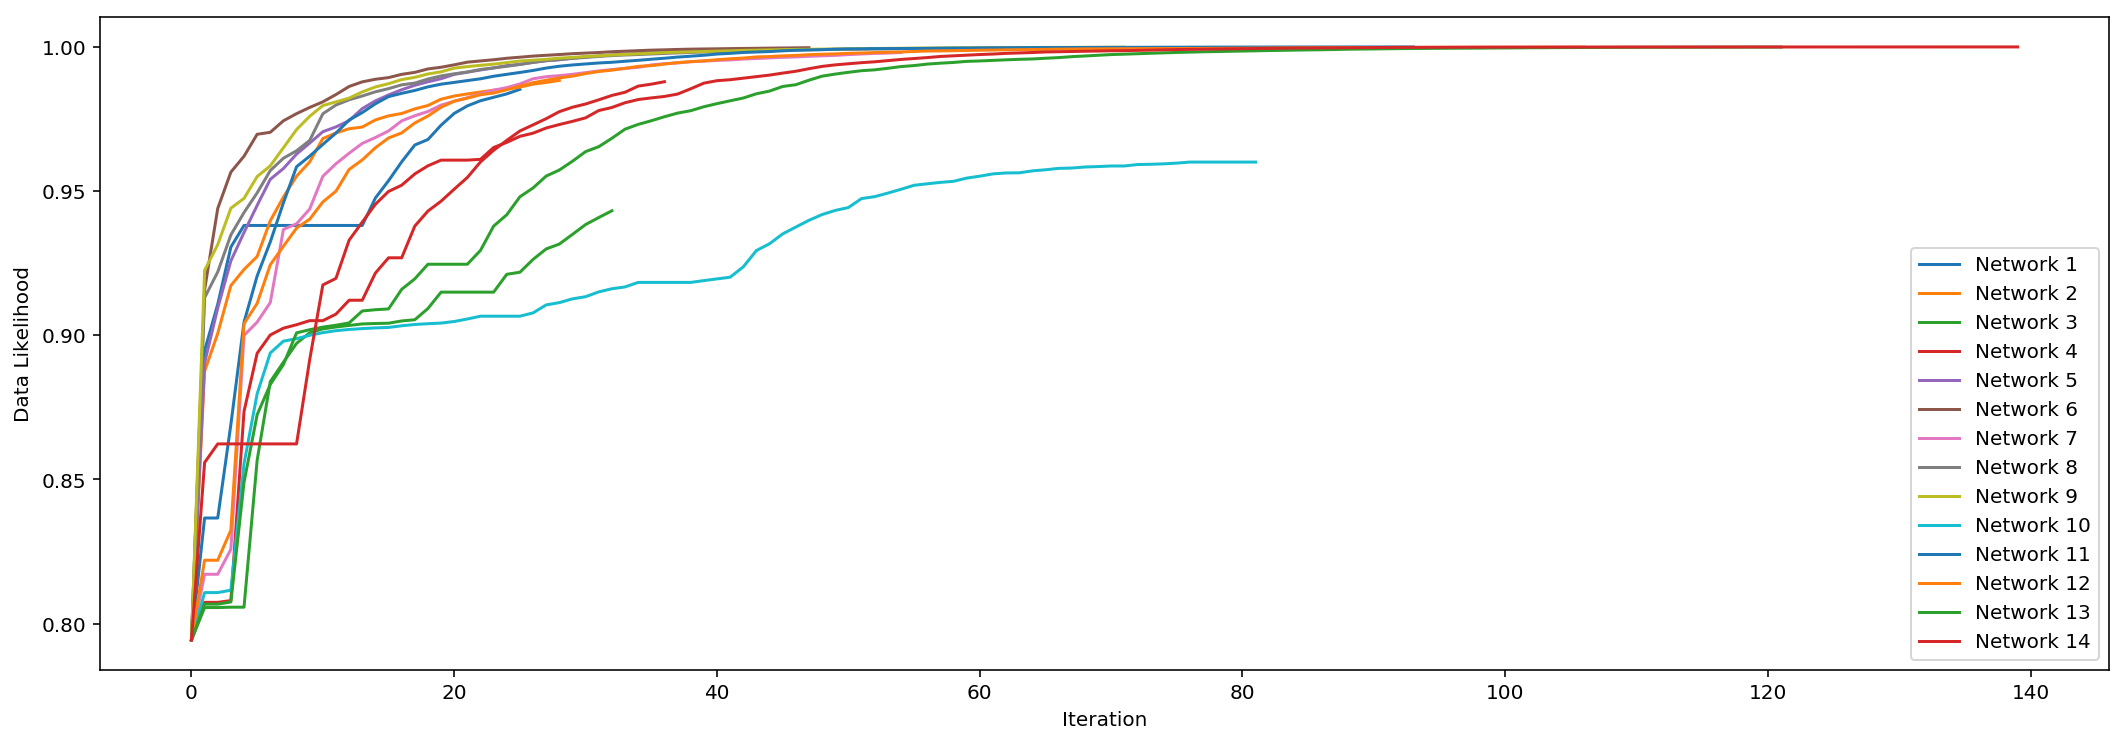

In [56]:
def anuran(X, T, network, itr, partition=False):
    
    if partition: 
        train_f = 0.8
        Xtrain, Ttrain, Xtest, T = ml.partition(X, T, (train_f, 1 - train_f), 
                                                classification=True)
        
        nnet = nn.NeuralNetworkClassifier(Xtrain.shape[1],
                                          network,
                                          np.unique(T).shape[0]) 
        nnet.train(Xtrain, Ttrain, itr)
        Y = nnet.use(Xtest)
        
    else:  
        nnet = nn.NeuralNetworkClassifier(X.shape[1],
                                          network,  
                                          np.unique(T).shape[0])
        nnet.train(X, T, itr)
        Y = nnet.use(X)
        
    return Y, T, nnet.getErrorTrace(), nnet

numberItr = 25
er = []

for i in range(14):
    a = np.random.randint(1, 50)
    b = np.random.randint(1, 5)
    print('Network', str(i+1) + ':', [a]*b,
          'with', numberItr, 'iterations.')

    Y, _T, error, _ = anuran(X, T, [a]*b, numberItr)
    er.append(error)
    numberItr = int(1.15 * numberItr)
    
plt.figure(figsize=(18,6))
for i, pl in enumerate(er):
    plt.plot(np.exp(-pl), label = 'Network '+str(i+1))

plt.xlabel('Iteration')
plt.ylabel('Data Likelihood')
plt.legend()
plt.show()

The graph above is quite uniform, and consistent through various trials of networks and iterations.  Each iteration generated a new network structure to add to randomness, and the number of iterations increased by a factor for 1.15 after each trial.  

Remember from regression, the goal is minimize the error.  However, with classification, the objective is to **increase** the likelihood of the inputs mapping to the target output. It can be seen from above that all the networks converge at roughly **75** iterations.  Thus, this will be a benchmark for finding the best neural network structure.

In [69]:
itr = 75
hidden = []
trainFraction = 0.80
numberRepetitions = 3

for i in range(10):
    a = np.random.randint(1, 50)
    b = np.random.randint(1, 5)
    hidden.append([a]*b)
    
results = trainNNs(X, T, trainFraction, hidden,
                   numberRepetitions, itr, classify=True)
summary = summarize(results)
best    = bestNetwork(summary)

pprint(summary)
printBest(best)

[[[49, 49], 0.0, 0.012508686587908269, 2.677406072616577],
 [[36, 36, 36], 0.0, 0.014593467685892982, 2.5690910816192627],
 [[46, 46], 0.0, 0.009497336113041464, 2.4733622074127197],
 [[3, 3, 3], 0.258860319666435, 0.26268241834607364, 0.8538098335266113],
 [[25], 0.0, 0.015288394718554553, 1.13848876953125],
 [[2, 2, 2, 2], 0.3498957609451008, 0.3483900857076674, 1.071660041809082],
 [[33, 33], 0.0, 0.012045401899467222, 2.4595179557800293],
 [[9, 9, 9, 9], 0.05217743803567292, 0.06161686356265925, 2.249819755554199],
 [[45, 45, 45], 0.0, 0.014825110030113506, 5.217631101608276],
 [[8, 8, 8], 0.02032661570535094, 0.0384526291406069, 1.3627660274505615]]

Best: [[46, 46], 0.0, 0.009497336113041464, 2.4733622074127197]

Hidden Layers [46, 46] Average Training 0.00 Testing 0.01 Took 2.4734 seconds


The above results indicate that over 3 repetitions and 100 iterations - the network `[46, 46]` shows to be the best.  It does have a total training and run time of 2.47 seconds, which is high compared to the network `[25]` with a similar fraction of outputs incorrectly classified for the testing data but less time doing the computations.  This is a potential impediment with applications that are require critical resources.  However, this experiment is not relying on time and thus the better network structure will suffice.  

Let's graph our results of the predicted versus actual target data.

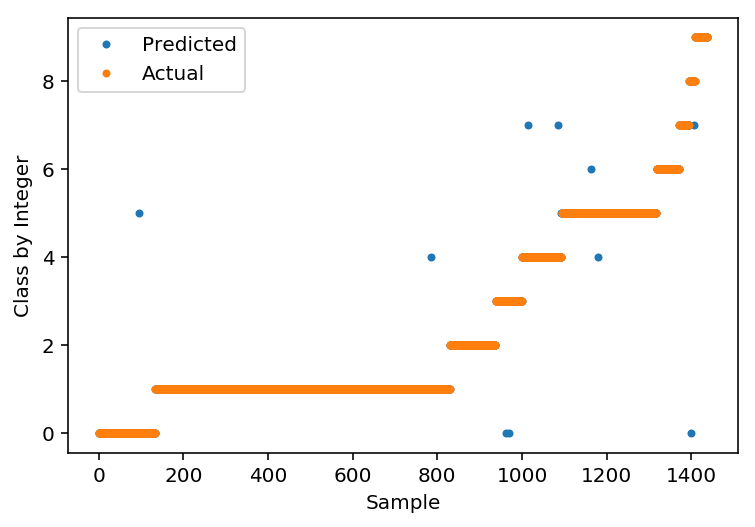

In [71]:
itr = 75
network = [46, 46]

Y, _T, error, nnet = anuran(X, T, network, itr, partition=True)
del error
plt.plot(np.hstack((Y, _T)), '.')
plt.legend(['Predicted', 'Actual'])
plt.xlabel('Sample')
plt.ylabel('Class by Integer')
plt.show()

Great! It is hard to conclude much from the above graph - it appears most of the values are overlapping.  To further analyzes the results, a `confusionMatrix(actual, predicted, classes)` function from the `mlutils.py` file will be used.

In [72]:
cm = ml.confusionMatrix(_T, Y, np.unique(_T))
print('----------------------------------------------------------------')
names = np.unique(data['Species'])
for i in range(0, len(np.unique(T)), 2):
    print(i, '--', '{:<20}'.format(names[i]), i+1, '--', names[i+1])

       0    1    2    3    4    5    6    7    8    9
    ------------------------------------------------------------
 0 | 99.3  0    0    0    0    0.7  0    0    0    0     (134 / 134)
 1 |  0   99.9  0    0    0.1  0    0    0    0    0     (696 / 696)
 2 |  0    0  100.0  0    0    0    0    0    0    0     (108 / 108)
 3 |  3.2  0    0   96.8  0    0    0    0    0    0     (62 / 62)
 4 |  0    0    0    0   96.8  1.1  0    2.1  0    0     (94 / 94)
 5 |  0    0    0    0    0.4 99.1  0.4  0    0    0     (224 / 224)
 6 |  0    0    0    0    0    0  100.0  0    0    0     (54 / 54)
 7 |  0    0    0    0    0    0    0  100.0  0    0     (23 / 23)
 8 |  7.1  0    0    0    0    0    0    7.1 85.7  0     (14 / 14)
 9 |  0    0    0    0    0    0    0    0    0  100.0   (30 / 30)
----------------------------------------------------------------
0 -- AdenomeraAndre       1 -- AdenomeraHylaedactylus
2 -- Ameeregatrivittata   3 -- HylaMinuta
4 -- HypsiboasCinerascens 5 -- HypsiboasCo

The above matrix gives a much nicer representation of the results.  Such that each column for some row shall total to 100%.  A value on the diagonal entry indicates every value was correctly classified, and for each percentage off is a misrepresentation of that class.  For example, AdenomeraAndre (class 0) was 99.3% correctly identified, and misrepresented as an HypsiboasCordobae (class 5) 0.70% of the time.  

These values are subject to change when a new trial is run, but the best network found is a well represented model of the graph.  An average value for incorrectly identified species on the test set of 0.009497 is phenomenal. The audible MFCCs values are good identifiers for the species of frogs.

As with the very first example, the model for this experiment can be represented with illustrating the hidden layer structure to not be so *invisible* to the user.  The weights are are noticeably smaller within each layer since there are so many more features and units across the network.

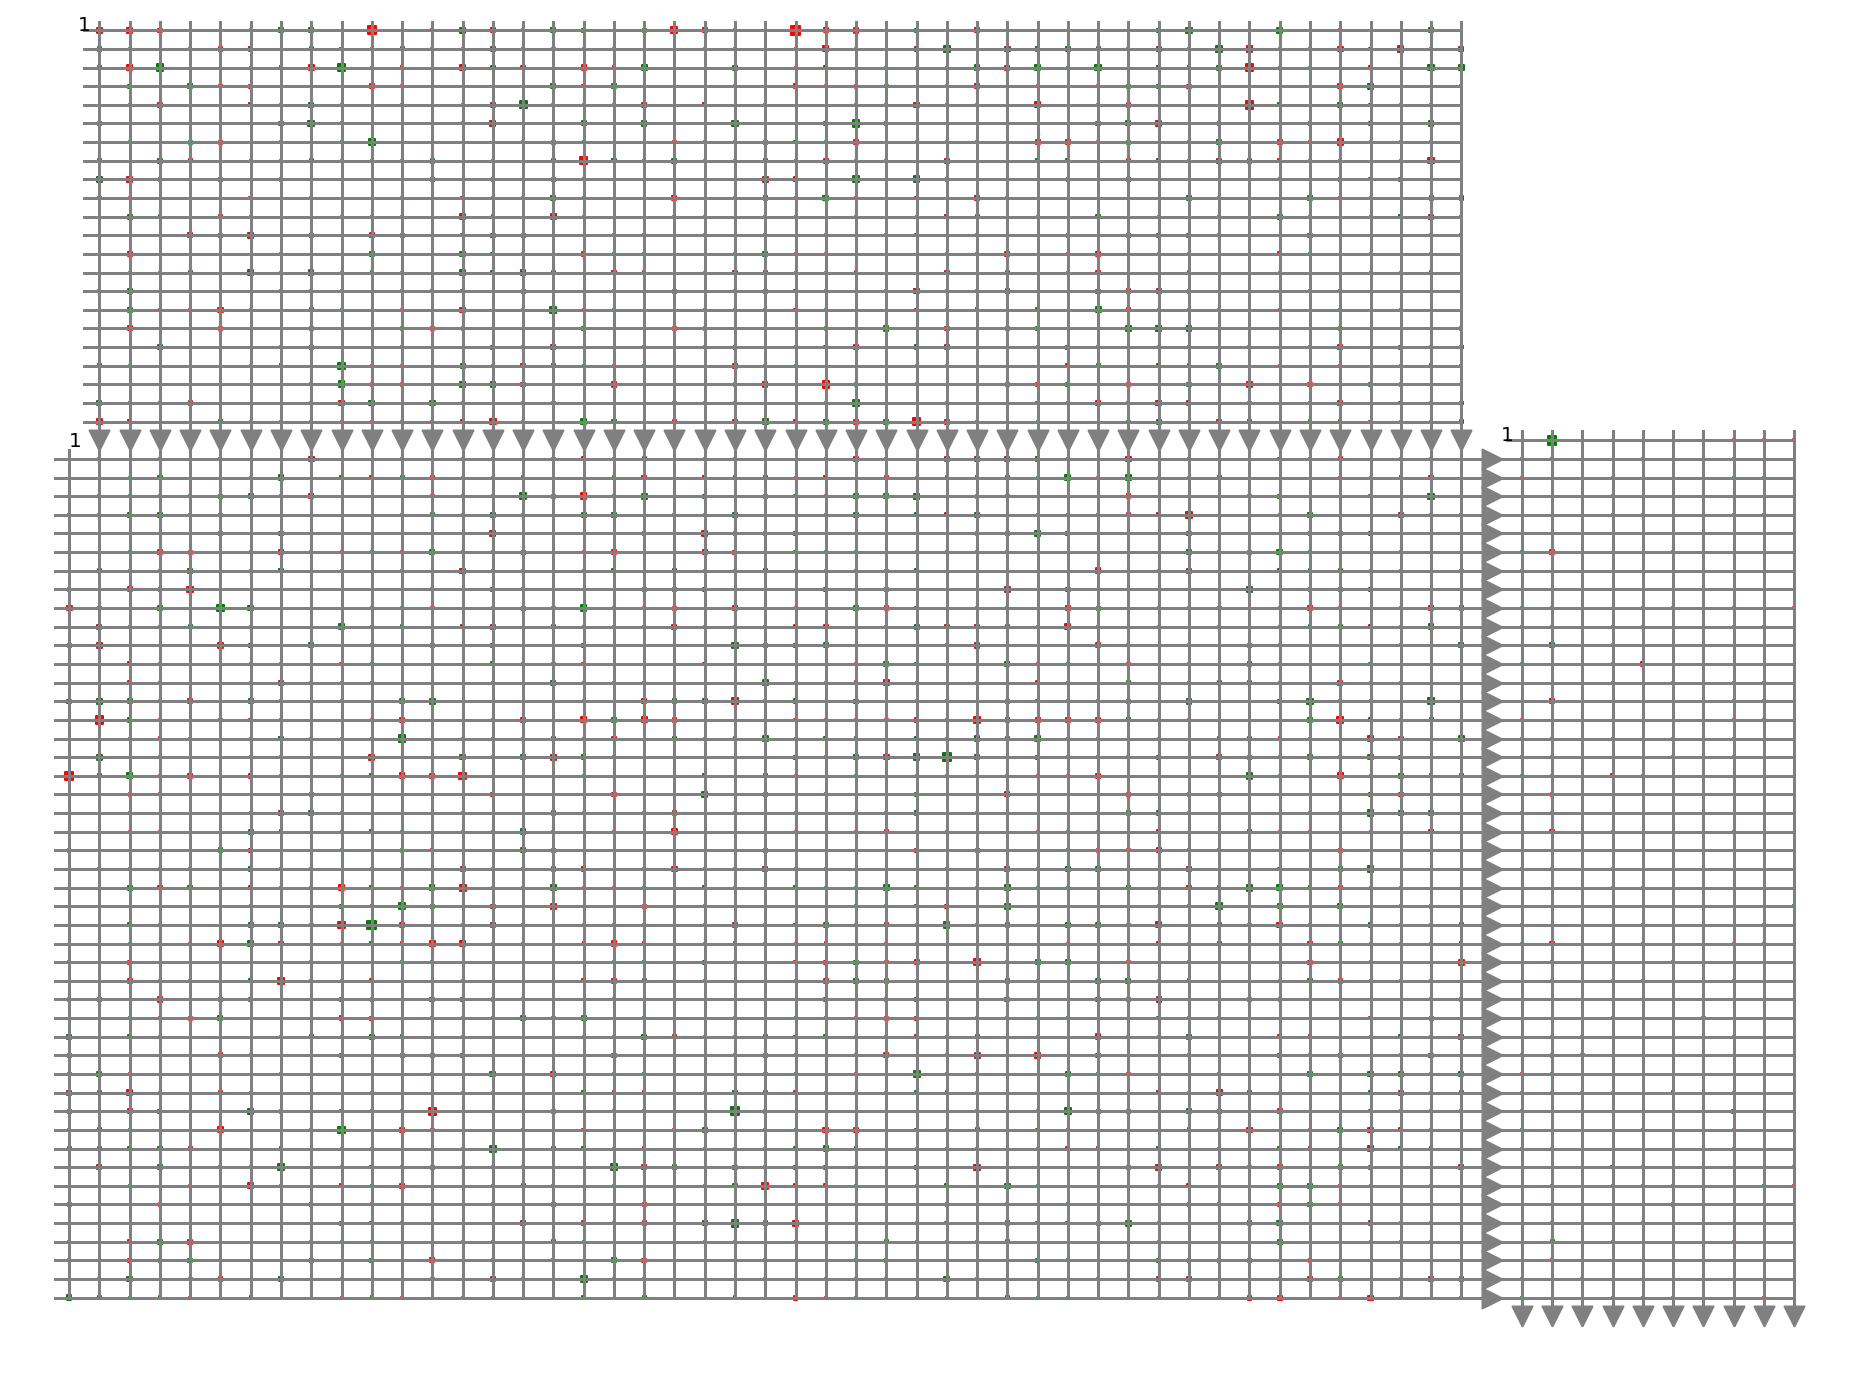

In [81]:
plt.figure(figsize=(16,12))
nnet.draw()

This concludes the experiments.  

\--